# Care plans

Care plans are used by staff to keep track of both current and planned procedures for the patient. Care plans are documented in five tables: carePlanCareProvider, carePlanEOL, carePlanGeneral, carePlanGoal, and carePlanInfectiousDisease.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
import pdvega

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Summarize data available in each table

## Examine data for one patient

## Hospitals with data available

In [3]:
query = query_schema + """
with cpc as ( select distinct patientunitstayid from careplancareprovider )
, cpeol as ( select distinct patientunitstayid from careplaneol )
, cpge as ( select distinct patientunitstayid from careplangeneral )
, cpgo as ( select distinct patientunitstayid from careplangoal )
, cpid as ( select distinct patientunitstayid from careplaninfectiousdisease )
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct cpc.patientunitstayid) as n_cpc
  , count(distinct cpeol.patientunitstayid) as n_cpeol
  , count(distinct cpge.patientunitstayid) as n_cpge
  , count(distinct cpgo.patientunitstayid) as n_cpgo
  , count(distinct cpid.patientunitstayid) as n_cpid
from patient pt
left join cpc
  on pt.patientunitstayid = cpc.patientunitstayid
left join cpeol
  on pt.patientunitstayid = cpeol.patientunitstayid
left join cpge
  on pt.patientunitstayid = cpge.patientunitstayid
left join cpgo
  on pt.patientunitstayid = cpgo.patientunitstayid
left join cpid
  on pt.patientunitstayid = cpid.patientunitstayid
group by pt.hospitalid
""".format()

df = pd.read_sql_query(query, con)
# convert to percent
cols = ['n_cpc', 'n_cpeol', 'n_cpge', 'n_cpgo', 'n_cpid']
for c in cols:
    df[c] = df[c].astype(float) / df['number_of_patients'] * 100.0
    
df.sort_values('number_of_patients', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,n_cpc,n_cpeol,n_cpge,n_cpgo,n_cpid
11,73,7059,86.669500,0.000000,99.065023,0.000000,0.000000
54,167,6092,52.954695,0.082075,99.753775,0.000000,0.016415
106,264,5237,96.429253,0.038190,98.644262,0.000000,0.000000
184,420,4679,99.251977,3.483650,96.281257,91.194700,1.816627
58,176,4328,52.356747,0.023105,99.745841,0.000000,0.000000
134,338,4277,97.685293,0.023381,99.415478,0.140285,0.023381
90,243,4243,97.784586,0.400660,97.407495,3.676644,5.467829
71,199,4240,91.910377,0.259434,95.353774,0.306604,0.141509
206,458,3701,98.324777,0.000000,99.000270,0.027020,0.000000
200,443,3656,92.970460,0.000000,99.234136,0.000000,0.000000


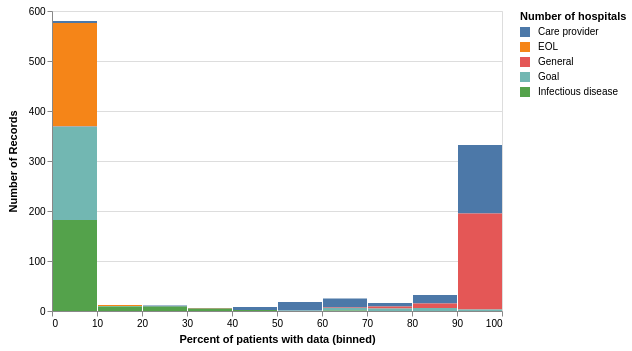

In [5]:
# rename columns within the call for clarity in the figure
column_label = {'n_cpc': 'Care provider',
               'n_cpeol': 'EOL',
                'n_cpge': 'General',
                'n_cpgo': 'Goal',
                'n_cpid': 'Infectious disease'}

df[cols].rename(columns=column_label).vgplot.hist(bins=10, stacked=True,
                                    var_name='Number of hospitals',
                                    value_name='Percent of patients with data')

As we can see, the majority of hospitals do not have data for the goal, infectious disease, and EOL tables. Conversely, the care provider and general tables have good coverage.